In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
)
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

In [2]:
import os
os.getcwd()

'c:\\Users\\Lilu\\Desktop\\classificaton_var_stars\\models\\without tsfresh\\another_noresample_nosmote'

In [3]:
os.chdir('..\\..\\..\\')

In [4]:
os.chdir('data')

In [5]:
# Подготовка данных для модели
y_labels = pd.read_csv('y_labels_100thsnd_withoutscaler.csv')

cnn_arrays = np.load('shuffled_combined_100thsnd_withoutscaler.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [6]:
selected_subtypes = ['RRAB', 'BY', 'DCEP', 'DSCT', 'EA', 'UG', 'EW', \
                     'M', 'SR', 'TTS']

# Фильтруем строки с нужными подтипами
filtered_y = y_labels[y_labels['variability_type'].isin(selected_subtypes)]


In [7]:

# Находим индексы в X_ts, соответствующие выбранным asas_sn_id
mask = np.isin(ids_ts, filtered_y['asas_sn_id'].values)
X_ts = X_ts[mask]
ids_ts = ids_ts[mask]
filtered_y = filtered_y[filtered_y['asas_sn_id'].isin(ids_ts)]

In [8]:
# Создание индексов для корректного разделения
indices = np.arange(len(X_ts))
# Стратифицированное разделение с сохранением индексов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    #y_labels['main_class'].values,
    filtered_y['variability_type'].values,
    indices,
    test_size=0.2,
    #stratify=y_labels['main_class'],
    stratify=filtered_y['variability_type'],
    random_state=42
)

In [9]:
# Создание индексов для корректного разделения
indices = np.arange(len(X_ts))
# Стратифицированное разделение с сохранением индексов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    indices,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [52946, 107976, 52946]

In [10]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
y_main = ohe_main.fit_transform(filtered_y[['variability_type']])

In [11]:
# Вычисление весов классов до SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(filtered_y['variability_type']),
    y=filtered_y['variability_type']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 1.5618289085545722,
 1: 5.2946,
 2: 2.6526052104208415,
 3: 0.8825804300716786,
 4: 0.529830881617132,
 5: 1.32365,
 6: 0.529777866720032,
 7: 0.5296188856656997,
 8: 5.018578199052133,
 9: 0.9588192683810214}

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['BY' 2712]
 ['DCEP' 800]
 ['DSCT' 1597]
 ['EA' 4799]
 ['EW' 7994]
 ['M' 3200]
 ['RRAB' 7995]
 ['SR' 7997]
 ['TTS' 844]
 ['UG' 4418]]


In [40]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [41]:
under_sampler = RandomUnderSampler(
    sampling_strategy={
        'BY': 1000,
        'DSCT': 1000,
        'EA': 1000,
        'DCEP': 800,
        'EW': 1000,
        'M': 1000,
        'RRAB': 1000,
        'UG': 1000,
        'SR': 1000,
        'TTS': 844,
    },
    random_state=42)


# Преобразование данных для SMOTE
n_samples, timesteps, features = X_train.shape
X_train_flat = X_train.reshape(n_samples, -1)
X_train_resampled_flat, y_train_resampled = under_sampler.fit_resample(X_train_flat, y_train)

all_ids_smote = ids_ts[idx_train]

# Восстановление 3D структуры
X_train_resampled = X_train_resampled_flat.reshape(-1, timesteps, features)
# Получаем индексы отобранных образцов
sampled_indices = under_sampler.sample_indices_
ids_train_resampled = all_ids_smote[sampled_indices]
# Генерация ID для синтетических данных
#original_ids = ids_ts[idx_train][sampled_indices[:len(X_train_flat)]]
#synthetic_ids = [f'synthetic_{i}' for i in range(len(y_train_resampled)-len(original_ids))]
#ids_resampled = np.concatenate([original_ids, synthetic_ids])

In [42]:
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[['BY' 1000]
 ['DCEP' 800]
 ['DSCT' 1000]
 ['EA' 1000]
 ['EW' 1000]
 ['M' 1000]
 ['RRAB' 1000]
 ['SR' 1000]
 ['TTS' 844]
 ['UG' 1000]]


In [43]:
unique, counts = np.unique(y_val, return_counts=True)
print(np.asarray((unique, counts)).T)

[['BY' 678]
 ['DCEP' 200]
 ['DSCT' 399]
 ['EA' 1200]
 ['EW' 1999]
 ['M' 800]
 ['RRAB' 1999]
 ['SR' 2000]
 ['TTS' 211]
 ['UG' 1104]]


In [44]:
under_sampler2 = RandomUnderSampler(
    sampling_strategy={
        'DCEP': 200,
        'DSCT': 300,
        'EA': 300,
        'BY': 300,
        'EW': 300,
        'M': 200,
        'RRAB': 300,
        'UG': 300,
        'SR': 300,
        'TTS': 211,
    },
    random_state=42)

n_samples, timesteps, features = X_val.shape
X_val_flat = X_val.reshape(n_samples, -1)

X_val_resampled_flat, y_val_resampled = under_sampler2.fit_resample(X_val_flat, y_val)

# Восстановление 3D структуры
X_val_resampled = X_val_resampled_flat.reshape(-1, timesteps, features)
# Получаем индексы отобранных образцов
sampled_indices = under_sampler2.sample_indices_
ids_val_resampled = all_ids_smote[sampled_indices]

In [45]:
# Объединение меток тренировочных (после SMOTE) и валидационных данных
combined_y = np.concatenate([y_train_resampled, y_val])

# Вычисление весов на объединенном наборе
unique_classes = np.unique(y_train_resampled)
class_weights = compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=y_train_resampled
)

# Создание словаря с правильными метками классов
class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}
class_weight_dict

{'BY': 0.9644,
 'DCEP': 1.2055,
 'DSCT': 0.9644,
 'EA': 0.9644,
 'EW': 0.9644,
 'M': 0.9644,
 'RRAB': 0.9644,
 'SR': 0.9644,
 'TTS': 1.142654028436019,
 'UG': 0.9644}

In [14]:
# Преобразование меток в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train_resampled, columns=['variability_type']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val_resampled, columns=['variability_type']))

NameError: name 'y_train_resampled' is not defined

In [47]:
n_samples, timesteps, features = X_train_resampled.shape

In [13]:
def scale_dataset(data):
    """Масштабирует данные с сохранением паддинга для каждого образца отдельно"""
    scaled_data = np.empty_like(data)
    
    for i in range(data.shape[0]):
        # Копируем признаки для безопасности
        mag = data[i, :, 0].copy()
        mag_err = data[i, :, 1].copy()
        mjd = data[i, :, 2].copy()
        
        # Определяем границу паддинга по MJD
        non_zero_mask = mjd != 0.0
        valid_length = np.sum(non_zero_mask)
        
        if valid_length > 0:
            # Масштабируем каждый признак отдельно
            for ch, feature in enumerate([mag, mag_err, mjd]):
                scaler = StandardScaler()
                scaled_part = scaler.fit_transform(feature[:valid_length].reshape(-1, 1)).flatten()
                feature[:valid_length] = scaled_part
        
        # Сохраняем масштабированные данные
        scaled_data[i, :, 0] = mag
        scaled_data[i, :, 1] = mag_err
        scaled_data[i, :, 2] = mjd
    
    return scaled_data

# Пример использования
X_train_scaled = scale_dataset(X_train)
X_val_scaled = scale_dataset(X_val)

In [ ]:
def augment_drop_shift_zero(mag, mag_err, mjd, drop_ratio=0.002):
    """
    Удаляет случайные наблюдения, сдвигает оставшиеся влево и заполняет конец нулями.
    
    Параметры:
        mag (np.array): Массив величин звезды.
        mag_err (np.array): Массив ошибок величин.
        mjd (np.array): Массив временных меток.
        drop_ratio (float): Доля наблюдений для удаления (0-1).
    
    Возвращает:
        Кортеж (mag_aug, mag_err_aug, mjd_aug).
    """
    n = len(mag)
    k = int(n * drop_ratio)
    
    # Случайные индексы для удаления
    drop_indices = np.random.choice(n, k, replace=False)
    mask = np.ones(n, dtype=bool)
    mask[drop_indices] = False
    
    # Удаляем выбранные наблюдения и сдвигаем влево
    mag_remaining = mag[mask]
    mag_err_remaining = mag_err[mask]
    mjd_remaining = mjd[mask]
    
    # Заполняем конец нулями до исходной длины
    mag_aug = np.zeros_like(mag)
    mag_aug[:len(mag_remaining)] = mag_remaining
    
    mag_err_aug = np.zeros_like(mag_err)
    mag_err_aug[:len(mag_err_remaining)] = mag_err_remaining
    
    mjd_aug = np.zeros_like(mjd)
    mjd_aug[:len(mjd_remaining)] = mjd_remaining
    
    return mag_aug, mag_err_aug, mjd_aug


In [7]:
def augment_drop_shift_zero(mag, mag_err, mjd, drop_ratio=0.002, noise_scale=0.2):
    """
    Удаляет наблюдения, добавляет шум и сохраняет класс.
    
    Параметры:
        noise_scale (float): Интенсивность шума (рекомендуется 0.1-0.5)
    """
    n = len(mag)
    k = int(n * drop_ratio)
    
    # Удаление точек
    drop_indices = np.random.choice(n, k, replace=False)
    mask = np.ones(n, dtype=bool)
    mask[drop_indices] = False
    
    mag_remaining = mag[mask]
    mag_err_remaining = mag_err[mask]
    mjd_remaining = mjd[mask]
    
    # Аккуратное добавление шума
    def add_noise(data, errors, scale):
        # Шум пропорционален исходным ошибкам
        noise = np.random.normal(loc=0, scale=scale * errors)
        return data + noise
    
    # Применяем шум только к реальным данным (исключая паддинг)
    valid_length = len(mag_remaining)
    if valid_length > 0:
        mag_remaining = add_noise(
            mag_remaining[:valid_length], 
            mag_err_remaining[:valid_length], 
            noise_scale
        )
        
        # Корректируем ошибки после добавления шума
        mag_err_remaining = mag_err_remaining * np.random.uniform(0.9, 1.1, size=valid_length)
    
    # Сборка результата
    mag_aug = np.zeros_like(mag)
    mag_aug[:valid_length] = mag_remaining
    
    mag_err_aug = np.zeros_like(mag_err)
    mag_err_aug[:valid_length] = mag_err_remaining
    
    mjd_aug = np.zeros_like(mjd)
    mjd_aug[:valid_length] = mjd_remaining
    
    return mag_aug, mag_err_aug, mjd_aug

In [9]:
eruptive_mask = (y_train == 'ERUPTIVE')
X_eruptive = X_train[eruptive_mask]
idx_eruptive = idx_train[eruptive_mask]

In [10]:
def augment_eruptive(X, idx, num_augmentations=3):
    augmented_data = []
    new_indices = []
    
    for i, (data, orig_idx) in enumerate(zip(X, idx)):
        for aug_id in range(num_augmentations):
            # data.shape = (500, 3)
            mag = data[:, 0]  # (500,)
            mag_err = data[:, 1]  # (500,)
            mjd = data[:, 2]  # (500,)
            
            # Применяем аугментацию (должна возвращать 500 шагов!)
            mag_aug, mag_err_aug, mjd_aug = augment_drop_shift_zero(
                mag, mag_err, mjd, drop_ratio=0.002, noise_scale=0.2
            )
            
            # Собираем обратно в (500, 3)
            augmented_sample = np.stack([mag_aug, mag_err_aug, mjd_aug], axis=1)
            augmented_data.append(augmented_sample)
            new_indices.append(-(orig_idx * 1000 + i))
    
    return np.array(augmented_data), np.array(new_indices)

In [11]:
# Генерация аугментированных данных
X_eruptive_aug, idx_eruptive_aug = augment_eruptive(X_eruptive, idx_eruptive)

In [12]:
X_train_augmented = np.concatenate([X_train, X_eruptive_aug])
y_train_augmented = np.concatenate([y_train, ['ERUPTIVE']*len(X_eruptive_aug)])
idx_train_augmented = np.concatenate([idx_train, idx_eruptive_aug])

# Проверка размерностей
assert len(X_train_augmented) == len(y_train_augmented) == len(idx_train_augmented)

In [13]:
# Создаем массив индексов для перемешивания
shuffled_indices = np.random.permutation(len(X_train_augmented))

# Применяем одинаковую перестановку ко всем данным
X_train = X_train_augmented[shuffled_indices]
y_train = y_train_augmented[shuffled_indices]
idx_train = idx_train_augmented[shuffled_indices]


In [8]:
# Создание индексов для корректного разделения
indices = np.arange(len(X_ts))
# Стратифицированное разделение с сохранением индексов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    indices,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

In [16]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
y_main = ohe_main.fit_transform(y_labels[['main_class']])

In [27]:
# Вычисление весов классов до SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.7715051266478511,
 1: 5.622285863056495,
 2: 0.4320595414349166,
 3: 1.0884677419354838,
 4: 3.4158810503005377}

In [28]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['ECLIPSING' 22393]
 ['ERUPTIVE' 3073]
 ['PULSATING' 39985]
 ['ROTATING' 15872]
 ['cataclysmic' 5057]]


In [15]:
n_samples, timesteps, features = X_train.shape

In [14]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения по F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/deltawithoutresamplebest_f1.keras',  
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения по val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/deltascalerwithoutresamplebest_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [16]:
# Преобразование меток в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train, columns=['variability_type']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['variability_type']))

In [21]:
# Преобразование меток в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [26]:
from astropy.timeseries import LombScargle
from sklearn.preprocessing import MinMaxScaler

def compute_phase(mjd, mag, min_period=0.1, max_period=100.0):
    """Вычисление фазы через Lomb-Scargle периодограмму."""
    try:
        # Исключаем нулевые значения паддинга
        mask = mjd != 0.0
        if np.sum(mask) < 10:
            return np.zeros_like(mjd)
        
        t = mjd[mask]
        y = mag[mask]
        
        # Вычисление периодограммы
        frequency, power = LombScargle(t, y).autopower(
            minimum_frequency=1/max_period,
            maximum_frequency=1/min_period
        )
        
        # Нахождение лучшего периода
        best_freq = frequency[np.argmax(power)]
        period = 1 / best_freq if best_freq != 0 else 0.0
        
        if period == 0:
            return np.zeros_like(mjd)
        
        # Вычисление фазы
        phase = (t / period) % 1
        phase_scaled = MinMaxScaler().fit_transform(phase.reshape(-1, 1)).flatten()
        
        # Восстановление с учетом паддинга
        full_phase = np.zeros_like(mjd)
        full_phase[mask] = phase_scaled
        return full_phase
    
    except:
        return np.zeros_like(mjd)

# Модифицируем обработку данных
X_train_scaled = np.empty((X_train.shape[0], X_train.shape[1], 4))  # Добавляем 4-й канал для фазы

for i in range(X_train.shape[0]):
    mag = X_train[i, :, 0].copy()
    mag_err = X_train[i, :, 1].copy()
    mjd = X_train[i, :, 2].copy()
    
    non_zero_mask = mjd != 0.0
    valid_length = np.sum(non_zero_mask)
    
    if valid_length > 0:
        # Масштабирование признаков
        scaler_mag = StandardScaler()
        mag[:valid_length] = scaler_mag.fit_transform(mag[:valid_length].reshape(-1, 1)).flatten()
        
        scaler_err = StandardScaler()
        mag_err[:valid_length] = scaler_err.fit_transform(mag_err[:valid_length].reshape(-1, 1)).flatten()
        
        scaler_mjd = StandardScaler()
        mjd_scaled = scaler_mjd.fit_transform(mjd[:valid_length].reshape(-1, 1)).flatten()
        
        # Вычисление фазы
        phase = compute_phase(mjd[:valid_length], mag[:valid_length])
        
        # Заполнение данных
        X_train_scaled[i, :valid_length, 0] = mag[:valid_length]
        X_train_scaled[i, :valid_length, 1] = mag_err[:valid_length]
        X_train_scaled[i, :valid_length, 2] = mjd_scaled
        X_train_scaled[i, :valid_length, 3] = phase[:valid_length]
    
    # Паддинг
    X_train_scaled[i, valid_length:, :] = 0.0

In [27]:

# Модифицируем обработку данных
X_val_scaled = np.empty((X_val.shape[0], X_val.shape[1], 4))  # Добавляем 4-й канал для фазы

for i in range(X_val.shape[0]):
    mag = X_val[i, :, 0].copy()
    mag_err = X_val[i, :, 1].copy()
    mjd = X_val[i, :, 2].copy()
    
    non_zero_mask = mjd != 0.0
    valid_length = np.sum(non_zero_mask)
    
    if valid_length > 0:
        # Масштабирование признаков
        scaler_mag = StandardScaler()
        mag[:valid_length] = scaler_mag.fit_transform(mag[:valid_length].reshape(-1, 1)).flatten()
        
        scaler_err = StandardScaler()
        mag_err[:valid_length] = scaler_err.fit_transform(mag_err[:valid_length].reshape(-1, 1)).flatten()
        
        scaler_mjd = StandardScaler()
        mjd_scaled = scaler_mjd.fit_transform(mjd[:valid_length].reshape(-1, 1)).flatten()
        
        # Вычисление фазы
        phase = compute_phase(mjd[:valid_length], mag[:valid_length])
        
        # Заполнение данных
        X_val_scaled[i, :valid_length, 0] = mag[:valid_length]
        X_val_scaled[i, :valid_length, 1] = mag_err[:valid_length]
        X_val_scaled[i, :valid_length, 2] = mjd_scaled
        X_val_scaled[i, :valid_length, 3] = phase[:valid_length]
    
    # Паддинг
    X_val_scaled[i, valid_length:, :] = 0.0

In [26]:
print("Mean:", X_val_scaled[0].min(axis=0))
print("Std :", X_val_scaled[0].max(axis=0))

Mean: [-2.10493427 -1.32688567 -2.08659659]
Std : [3.69952651 8.82192986 1.40523167]


In [17]:
def residual_block(x, filters, dilation_rate, kernel_size=3):
    # Residual block с расширенной сверткой
    original_x = x
    x = Conv1D(filters*2, kernel_size,
              padding='causal',
              dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Gate branch
    gated = Conv1D(filters*2, kernel_size,
                  padding='causal',
                  dilation_rate=dilation_rate)(original_x)
    gated = BatchNormalization()(gated)
    gated = Activation('sigmoid')(gated)

    # Комбинирование
    x = Multiply()([x, gated])

    # Residual connection
    x = Conv1D(filters, 1, padding='same')(x)
    res = Add()([original_x, x])

    return res

def build_wavenet_model(input_shape, num_classes):
    # Вход для временных рядов
    ts_input = Input(shape=input_shape, name='ts_input')

    # Начальный слой
    x = Conv1D(64, 3, padding='causal')(ts_input)

    # Стек residual блоков с экспоненциально растущими dilation rates
    dilation_rates = [1, 2, 4, 8, 16, 32]
    for i, rate in enumerate(dilation_rates):
        x = residual_block(x, filters=64, dilation_rate=rate)
        x = Dropout(0.2)(x)

    # Финальные слои обработки временных рядов
    x = Conv1D(128, 3, padding='causal')(x)
    x = GlobalAveragePooling1D()(x)

    # Классификатор
    output = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    output = Dropout(0.4)(output)
    output = Dense(num_classes, activation='softmax')(output)

    return Model(inputs=ts_input, outputs=output)

In [18]:
# Компиляция модели
model = build_wavenet_model(
    #input_shape=(timesteps, features),
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    num_classes=len(ohe_main.categories_[0])
)
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[F1Score(average='macro')]
)

In [28]:
input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])

In [29]:
input_shape

(500, 3)

In [26]:
model.save("model.keras")

lomb

In [ ]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - f1_score: 0.3372 - loss: 2.0894
Epoch 1: val_f1_score improved from -inf to 0.40112, saving model to /content/drive/MyDrive/lombwithoutresamplebest_f1.keras

Epoch 1: val_loss improved from inf to 1.66465, saving model to /content/drive/MyDrive/lombscalerwithoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - f1_score: 0.3374 - loss: 2.0884 - val_f1_score: 0.4011 - val_loss: 1.6647
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - f1_score: 0.4965 - loss: 1.3521
Epoch 2: val_f1_score improved from 0.40112 to 0.51975, saving model to /content/drive/MyDrive/lombwithoutresamplebest_f1.keras

Epoch 2: val_loss improved from 1.66465 to 1.29650, saving model to /content/drive/MyDrive/lombscalerwithoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - f1_score: 0.4965 - loss: 1.3520 - val_f1_score: 0.5198 - val_loss: 1.2965
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - f1_score: 0.5372 

In [23]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 13
Train F1: 0.6570
Train loss: 0.9467
Validation F1: 0.6566
Validation Loss: 0.9721


331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step


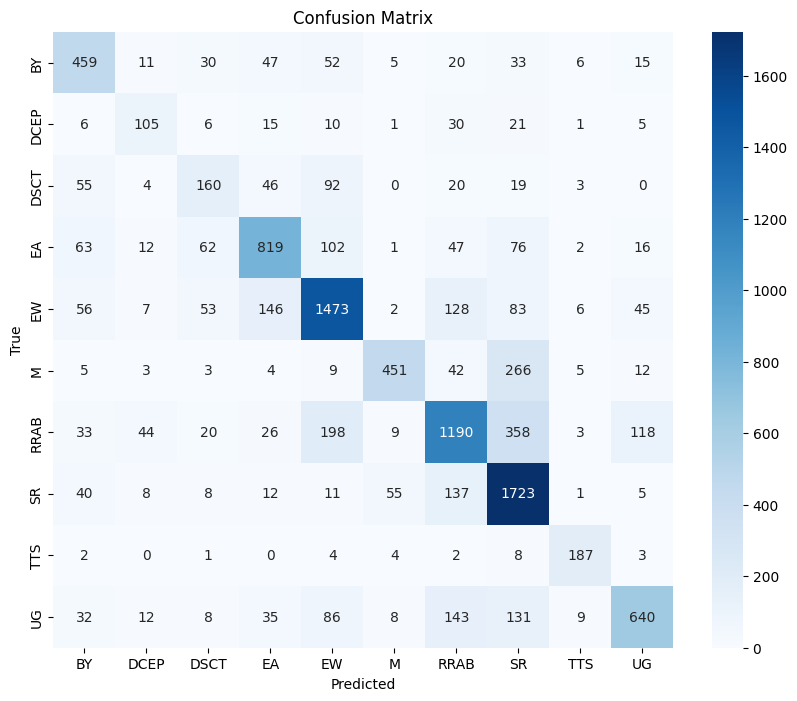

In [24]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

#  Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#  Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          BY     0.6112    0.6770    0.6424       678
        DCEP     0.5097    0.5250    0.5172       200
        DSCT     0.4558    0.4010    0.4267       399
          EA     0.7122    0.6825    0.6970      1200
          EW     0.7231    0.7369    0.7299      1999
           M     0.8414    0.5637    0.6751       800
        RRAB     0.6765    0.5953    0.6333      1999
          SR     0.6339    0.8615    0.7304      2000
         TTS     0.8386    0.8863    0.8618       211
          UG     0.7451    0.5797    0.6521      1104

    accuracy                         0.6805     10590
   macro avg     0.6748    0.6509    0.6566     10590
weighted avg     0.6885    0.6805    0.6774     10590



noresample standatd

In [87]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.3404 - loss: 2.1090
Epoch 1: val_f1_score improved from -inf to 0.49705, saving model to /content/drive/MyDrive/withoutresamplebest_f1.keras

Epoch 1: val_loss improved from inf to 1.42938, saving model to /content/drive/MyDrive/withoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - f1_score: 0.3406 - loss: 2.1079 - val_f1_score: 0.4971 - val_loss: 1.4294
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5102 - loss: 1.3421
Epoch 2: val_f1_score improved from 0.49705 to 0.51846, saving model to /content/drive/MyDrive/withoutresamplebest_f1.keras

Epoch 2: val_loss improved from 1.42938 to 1.29544, saving model to /content/drive/MyDrive/withoutresamplebest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - f1_score: 0.5103 - loss: 1.3419 - val_f1_score: 0.5185 - val_loss: 1.2954
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5500 - loss: 1.2173
Epoch 3: val_f1_score 

In [88]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 22
Train F1: 0.7020
Train loss: 0.8484
Validation F1: 0.6927
Validation Loss: 0.9346


331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step


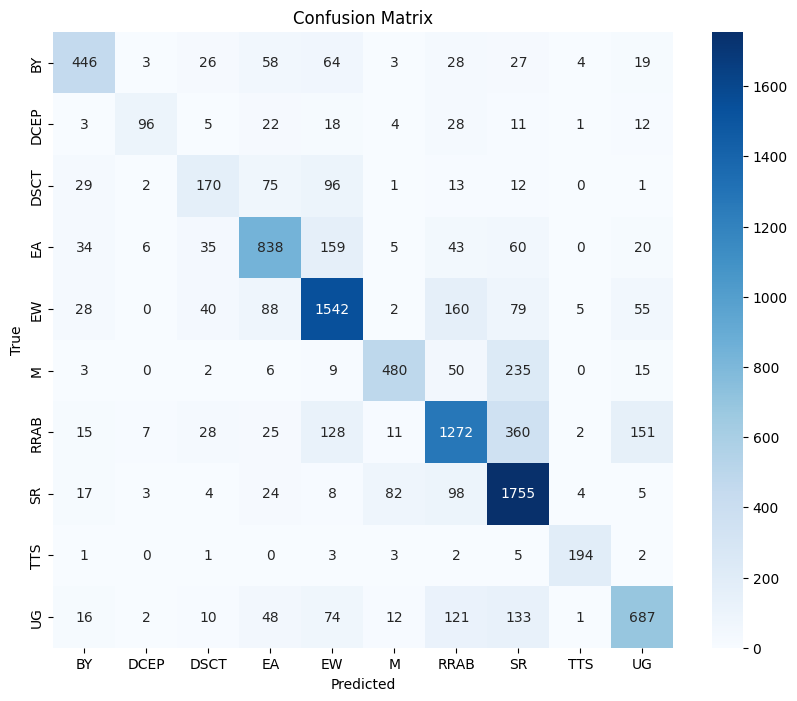

In [89]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

#  Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#  Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

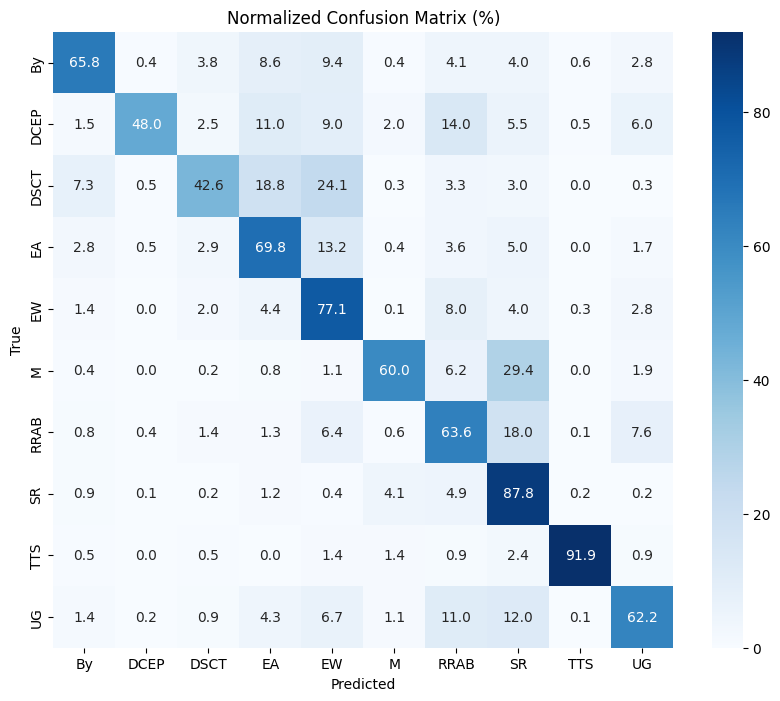

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных (замените на ваши)
cm = np.array([
    [446, 3, 26, 58, 64, 3, 28, 27, 4, 19],
    [3, 96, 5, 22, 18, 4, 28, 11, 1, 12],
    [29, 2, 170, 75, 96, 1, 13, 12, 0, 1],
    [34, 6, 35, 838, 159, 5, 43, 60, 0, 20],
    [28, 0, 40, 88, 1542, 2, 160, 79, 5, 55],
    [3, 0, 2, 6, 9, 480, 50, 235, 0, 15],
    [15, 7, 28, 25, 128, 11, 1272, 360, 2, 151],
    [17, 3, 4, 24, 8, 82, 98, 1755, 4, 5],
    [1, 0, 1, 0, 3, 3, 2, 5, 194, 2],
    [16, 2, 10, 48, 74, 12, 121, 133, 1, 687],
])

# Нормировка по строкам
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Визуализация
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=['By', 'DCEP', 'DSCT', 'EA', 'EW', 'M', 'RRAB', 'SR', 'TTS', 'UG'],
    yticklabels=['By', 'DCEP', 'DSCT', 'EA', 'EW', 'M', 'RRAB', 'SR', 'TTS', 'UG']
)
# Поворот подписей осей

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (%)")
plt.show()

In [90]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          BY     0.7534    0.6578    0.7024       678
        DCEP     0.8067    0.4800    0.6019       200
        DSCT     0.5296    0.4261    0.4722       399
          EA     0.7078    0.6983    0.7030      1200
          EW     0.7339    0.7714    0.7522      1999
           M     0.7960    0.6000    0.6842       800
        RRAB     0.7008    0.6363    0.6670      1999
          SR     0.6556    0.8775    0.7505      2000
         TTS     0.9194    0.9194    0.9194       211
          UG     0.7104    0.6223    0.6634      1104

    accuracy                         0.7063     10590
   macro avg     0.7314    0.6689    0.6916     10590
weighted avg     0.7108    0.7063    0.7026     10590



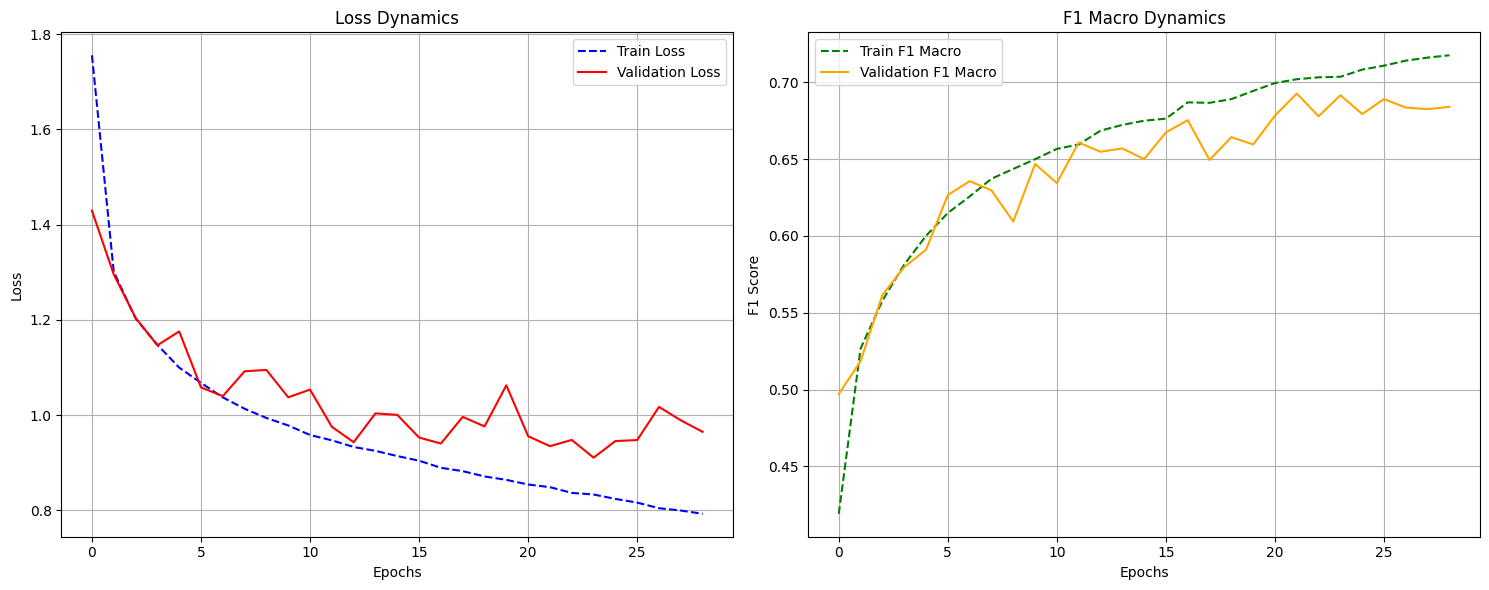

In [92]:
# Создаем фигуру
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

resample

In [53]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - f1_score: 0.2964 - loss: 2.6760
Epoch 1: val_f1_score improved from -inf to 0.31257, saving model to /content/drive/MyDrive/11best_f1.keras

Epoch 1: val_loss improved from inf to 2.37052, saving model to /content/drive/MyDrive/11best_loss.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - f1_score: 0.2976 - loss: 2.6726 - val_f1_score: 0.3126 - val_loss: 2.3705
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - f1_score: 0.4737 - loss: 1.9463
Epoch 2: val_f1_score did not improve from 0.31257

Epoch 2: val_loss did not improve from 2.37052
76/76 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - f1_score: 0.4739 - loss: 1.9454 - val_f1_score: 0.1953 - val_loss: 2.6782
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - f1_score: 0.5177 - loss: 1.6930
Epoch 3: val_f1_score improved from 0.31257 to 0.36095, saving model to /content/drive/MyDrive/11best_f1.keras

Epoch 3: val_loss improved from 2.37052 to 2.09627, saving model to /content/drive/MyDr

In [54]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 24
Train F1: 0.6740
Train loss: 1.0073
Validation F1: 0.6546
Validation Loss: 1.1505


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


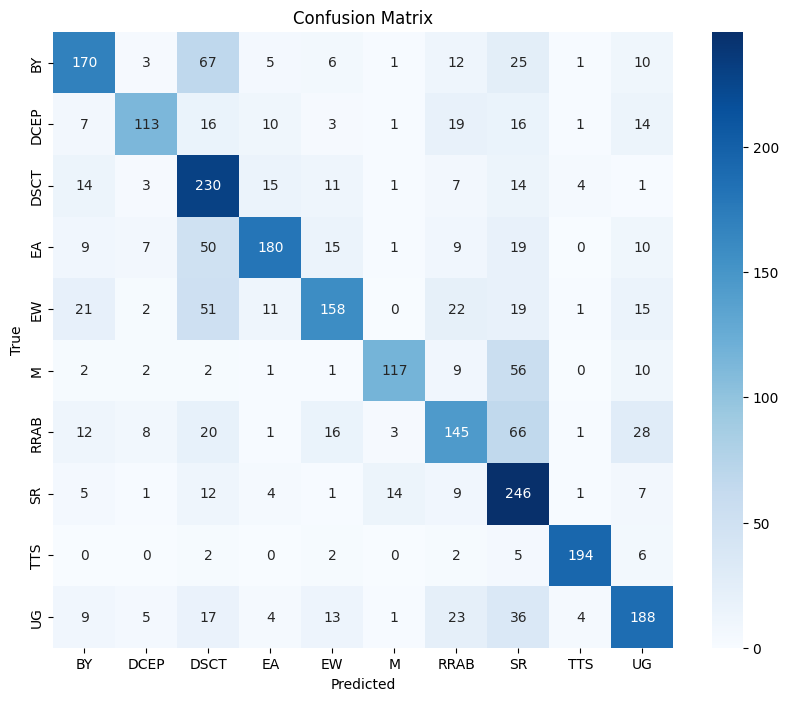

In [55]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

#  Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#  Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          BY     0.6827    0.5667    0.6193       300
        DCEP     0.7847    0.5650    0.6570       200
        DSCT     0.4925    0.7667    0.5997       300
          EA     0.7792    0.6000    0.6780       300
          EW     0.6991    0.5267    0.6008       300
           M     0.8417    0.5850    0.6903       200
        RRAB     0.5642    0.4833    0.5206       300
          SR     0.4900    0.8200    0.6135       300
         TTS     0.9372    0.9194    0.9282       211
          UG     0.6505    0.6267    0.6384       300

    accuracy                         0.6422      2711
   macro avg     0.6922    0.6459    0.6546      2711
weighted avg     0.6752    0.6422    0.6442      2711



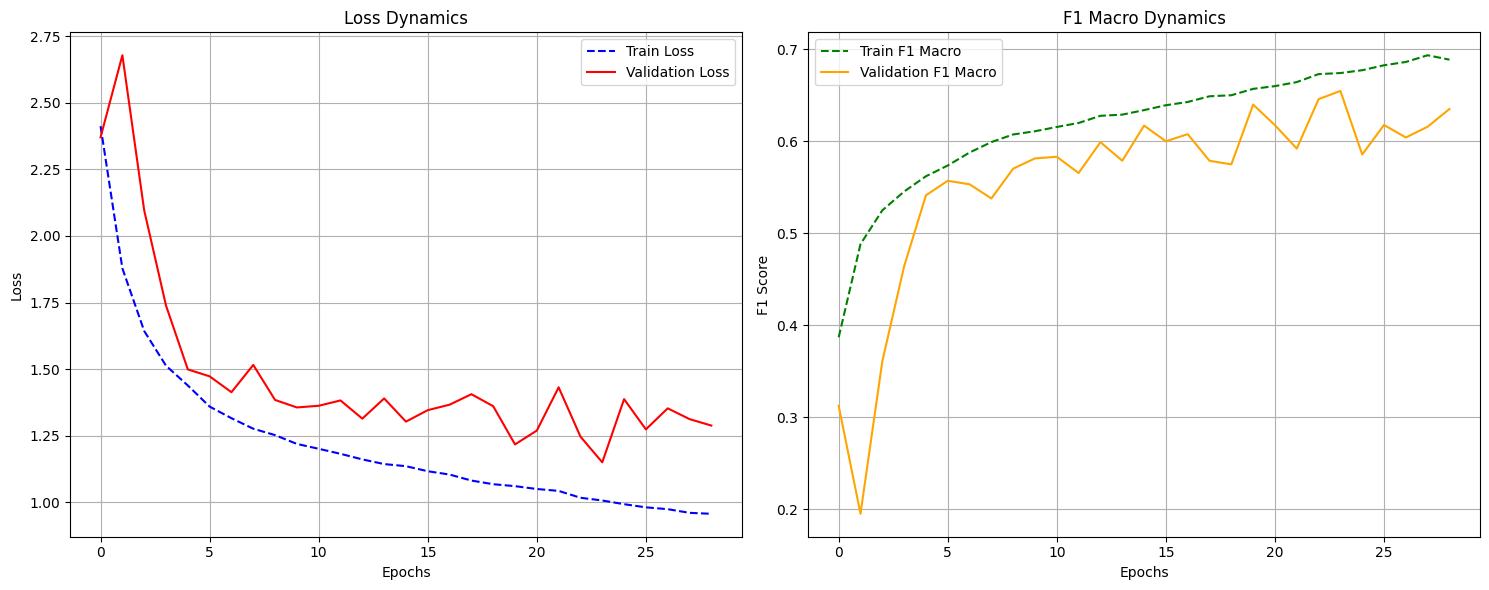

In [60]:
# Создаем фигуру
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 23
Train F1: 0.6372
Train loss: 0.7635
Validation F1: 0.6283
Validation Loss: 0.8231


675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step


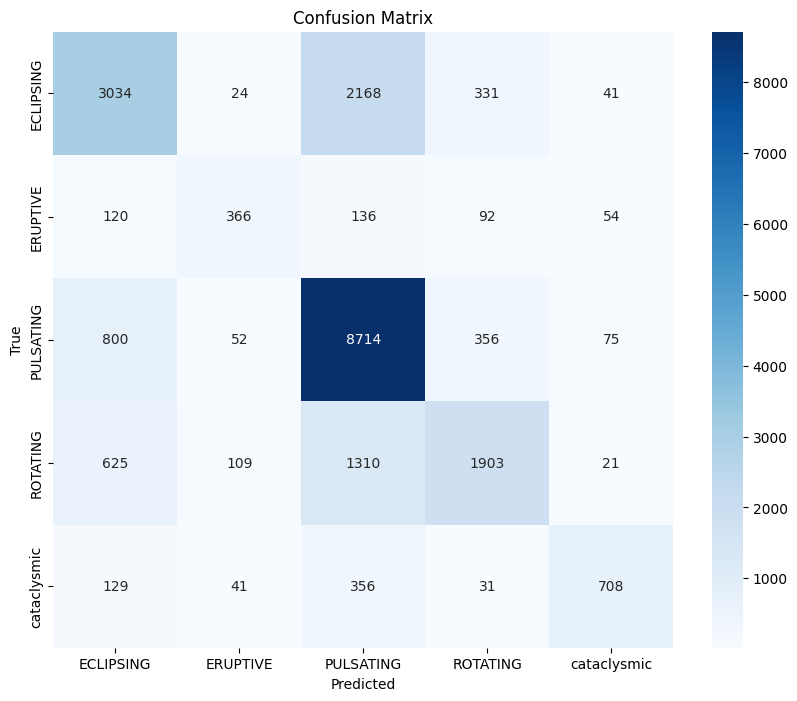

In [53]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

#  Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#  Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

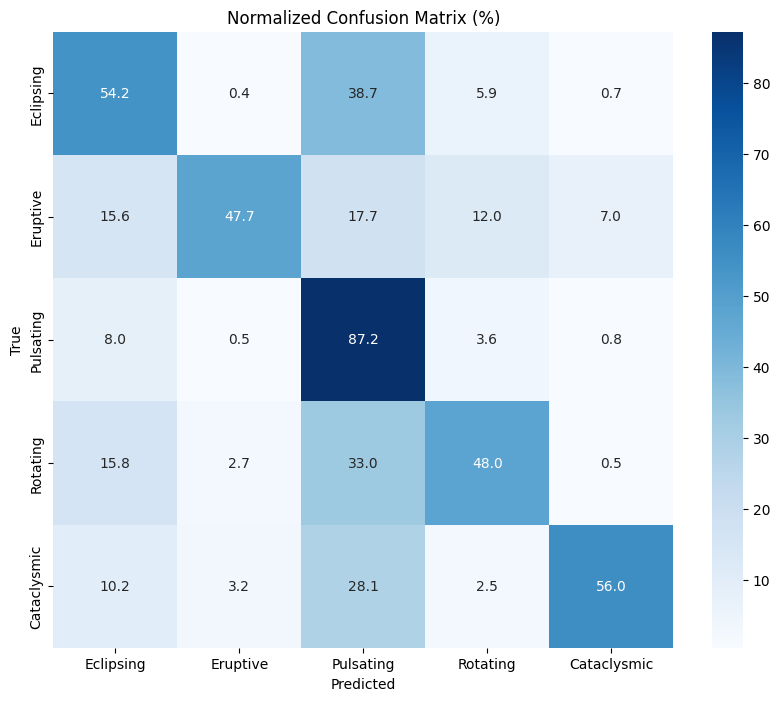

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных (замените на ваши)
cm = np.array([
    [3034, 24, 2168, 331, 41],
    [120, 366, 136, 92, 54],
    [800, 52, 8714, 356, 75],
    [625, 109, 1310, 1903, 21],
    [129, 41, 356, 31, 708],
])

# Нормировка по строкам
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Визуализация
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=['Eclipsing', 'Eruptive', 'Pulsating', 'Rotating', 'Cataclysmic'],
    yticklabels=['Eclipsing', 'Eruptive', 'Pulsating', 'Rotating', 'Cataclysmic']
)
# Поворот подписей осей

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (%)")
plt.show()

In [54]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.6444    0.5420    0.5888      5598
    ERUPTIVE     0.6182    0.4766    0.5382       768
   PULSATING     0.6870    0.8717    0.7684      9997
    ROTATING     0.7014    0.4796    0.5697      3968
 cataclysmic     0.7875    0.5597    0.6543      1265

    accuracy                         0.6818     21596
   macro avg     0.6877    0.5859    0.6239     21596
weighted avg     0.6821    0.6818    0.6705     21596



In [26]:
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/lombnoresamplehistory11.csv')

In [2]:
history = pd.read_csv('wavehistory.csv')

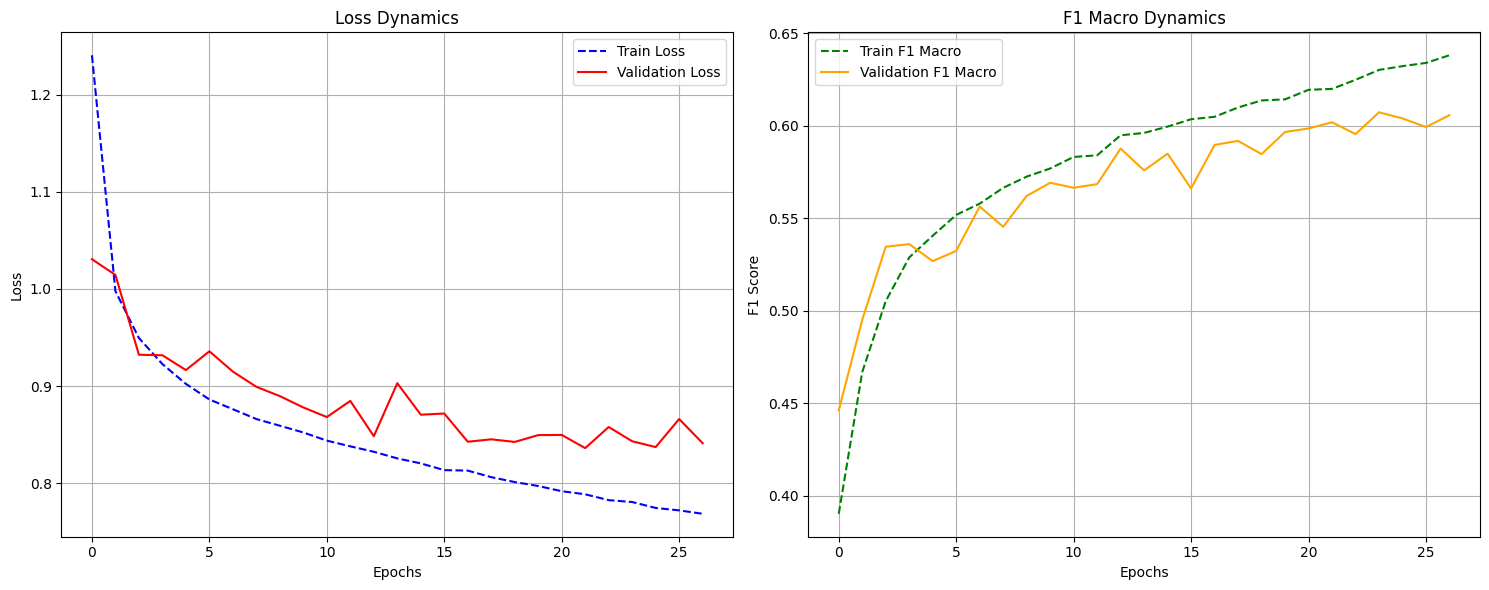

In [4]:
# Создаем фигуру
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()